In [1]:
from datetime import datetime

# print date as date accessed
date_accessed = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Date accessed: {date_accessed}")

Date accessed: 2024-10-12 00:19:42


In [2]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *

In [3]:
station_id = 'PROF_OWEG'
ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
data = ds.wind_speed.sel(range=slice(10,500))
data

<xarray.DataArray 'wind_speed' (range: 18, time: 52560)> Size: 4MB
[946080 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 420kB 2018-01-02 ... 2024-01-01
  * range    (range) int64 144B 10 100 125 150 175 200 ... 400 425 450 475 500
    station  <U9 36B ...

- The idea is, not all instances have wind speed values at all vertical levels. 
- During some instances, wind speed at all the vertical levels might be nans. 
- During some instances, wind speed at some vertical levels might be nans, while the non-missing are insufficient for a complete profile building. 
- During some instances, wind speed at some vertical levels might be nans, while the non-missing are sufficient for a complete profile building. 
- In such scenarios, we need provide the vertical levels having non-missing values in computing the Chebyshev coefficients. 

In [6]:
# checking normalization function
ref_H = np.array([10] + list(range(100, 501, 25)))
H = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 400])
print(ref_H, H, normalize(H,ref_H), normalize(ref_H, ref_H))

H = Z.flatten()[1:-1]
U = M.values.flatten()[1:-1]

# Normalize H
Hn = normalize(H, ref_H=ref_H)

# Remove NaN values
Indx = np.where(~np.isnan(U))[0]
Ha = Hn[Indx]
Ua = U[Indx]
N = len(Ua)

print(Ha, Ua)

[ 10 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500] [ 10  20  30  40  50  60  70  80  90 100 400] [-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469 -0.79591837
 -0.75510204 -0.71428571 -0.67346939 -0.63265306  0.59183673] [-1.         -0.63265306 -0.53061224 -0.42857143 -0.32653061 -0.2244898
 -0.12244898 -0.02040816  0.08163265  0.18367347  0.28571429  0.3877551
  0.48979592  0.59183673  0.69387755  0.79591837  0.89795918  1.        ]
[-0.63265306 -0.53061224 -0.42857143 -0.32653061 -0.2244898  -0.12244898
 -0.02040816  0.08163265  0.18367347  0.28571429  0.3877551   0.48979592
  0.59183673  0.69387755  0.79591837  0.89795918] [4.615013  4.778585  4.977586  5.1911383 5.1355457 5.005119  5.0563755
 5.201278  5.4222364 5.744564  5.7190676 5.551367  5.6087217 5.635025
 5.5807557 5.4385514]


In [14]:
spline_left(1)

array(5.29634714)

In [15]:
spline_left = interp1d(Ha, Ua, kind='linear', fill_value='extrapolate')
Uax = spline_left([-1])
spline_right = interp1d(Ha, Ua, kind='linear', fill_value='extrapolate')
Uay = spline_right([1])

print(Uax, Uay)

Ua = np.concatenate([Uax, Ua, Uay])
Ha = np.concatenate([-1 + np.zeros(1), Ha, 1 + np.zeros(1)])

print(Ha, Ua)

[4.02615452] [5.29634714]
[-1.         -0.63265306 -0.53061224 -0.42857143 -0.32653061 -0.2244898
 -0.12244898 -0.02040816  0.08163265  0.18367347  0.28571429  0.3877551
  0.48979592  0.59183673  0.69387755  0.79591837  0.89795918  1.        ] [4.02615452 4.61501312 4.77858496 4.97758579 5.19113827 5.13554573
 5.00511885 5.0563755  5.20127821 5.42223644 5.74456406 5.71906757
 5.55136681 5.60872173 5.63502502 5.58075571 5.43855143 5.29634714]


In [18]:
PL = Chebyshev_Basu(Ha, poly_order=poly_order, CPtype=CPtype)
Coeff = np.linalg.pinv(PL) @ Ua
Coeff

array([ 5.03792388,  0.67975935, -0.31054871, -0.05968217, -0.08990165])

<xarray.DataArray 'wind_speed' ()> Size: 8B
np.int64(29581)
Coordinates:
    station  <U9 36B ... non-missing instances
Bias: -0.0052
MAE: 0.0884
RMSE: 0.1131
Rmax: 0.2789


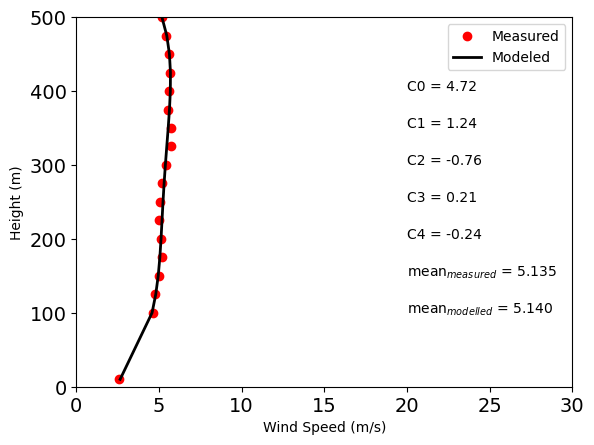

In [4]:
# find data only with non-missing instances
station_id = 'PROF_OWEG'
ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
data = ds.wind_speed.sel(range=slice(10,500))

non_missing_mask = data.notnull().all(dim='range')
non_missing_data = data.sel(time=non_missing_mask.time)
print(non_missing_mask.sum(dim='time'), 'non-missing instances')

# randomly select one profile for visualization
np.random.seed(14000)
time_idx = np.random.choice(np.where(non_missing_mask)[0])
M = non_missing_data.isel(time=time_idx)
Z = M.range.values

poly_order = 4
CPtype = 1
Coeff = Chebyshev_Coeff(Z, M.values,poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
Mp = WindProfile(Z,Coeff, poly_order=poly_order,CPtype=CPtype,ref_H=ref_H)
# Calculate statistics
Bias = np.mean(M - Mp)
MAE = np.mean(np.abs(M - Mp))
RMSE = np.sqrt(np.mean((M - Mp)**2))
Rmax = np.max(np.abs(M - Mp))

# Print the statistics
print(f'Bias: {Bias:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'RMSE: {RMSE:.4f}')
print(f'Rmax: {Rmax:.4f}')

# Create Coeff_tot array
Coeff_tot = np.zeros(10)
Coeff_tot[:len(Coeff)] = Coeff

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(Mp, Z, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'C0 = {Coeff_tot[0]:.2f}')
plt.text(20, 350, f'C1 = {Coeff_tot[1]:.2f}')
plt.text(20, 300, f'C2 = {Coeff_tot[2]:.2f}')
plt.text(20, 250, f'C3 = {Coeff_tot[3]:.2f}')
plt.text(20, 200, f'C4 = {Coeff_tot[4]:.2f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {Mp.mean():.3f}')
plt.savefig(f'data/Figures/chebyshev_fit_with_p{poly_order}_no-missing.png')

In [7]:
poly_order = 4
for CPtype in range(1, 3):
    for poly_order in range(1, 11):
        Coeff = Chebyshev_Coeff(Z, M.values,poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
        Mp = WindProfile(Z,Coeff, poly_order=poly_order,CPtype=CPtype,ref_H=ref_H)

        print(f'CPtype: {CPtype}, Poly order: {poly_order}: {Coeff[0]}, mean wind: {M.mean().values}')

CPtype: 1, Poly order: 1: 4.896571125653318, mean wind: 5.134591579437256
CPtype: 1, Poly order: 2: 4.727759993346917, mean wind: 5.134591579437256
CPtype: 1, Poly order: 3: 4.7320499006305266, mean wind: 5.134591579437256
CPtype: 1, Poly order: 4: 4.786522705819909, mean wind: 5.134591579437256
CPtype: 1, Poly order: 5: 4.806684627948884, mean wind: 5.134591579437256
CPtype: 1, Poly order: 6: 4.777433590101597, mean wind: 5.134591579437256
CPtype: 1, Poly order: 7: 4.684531133150809, mean wind: 5.134591579437256
CPtype: 1, Poly order: 8: 4.806505067860531, mean wind: 5.134591579437256
CPtype: 1, Poly order: 9: 5.342663447625139, mean wind: 5.134591579437256
CPtype: 1, Poly order: 10: 5.187175313781552, mean wind: 5.134591579437256
CPtype: 2, Poly order: 1: 4.896571125653317, mean wind: 5.134591579437256
CPtype: 2, Poly order: 2: 5.0868704399222615, mean wind: 5.134591579437256
CPtype: 2, Poly order: 3: 5.09065155945188, mean wind: 5.134591579437256
CPtype: 2, Poly order: 4: 5.13151060

In [91]:
import numpy as np
import xarray as xr

# Define the station ID and open the dataset
station_id = 'PROF_OWEG'
ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
data = ds.wind_speed.sel(range=slice(10, 500))

# Define the number of required non-missing points for intermediate range
intermediate_non_missing_points = 5

# Masks to ensure non-missing points in each segment
first_segment_mask = data.sel(range=slice(100, 200)).notnull().sum(dim='range') >= 1
last_segment_mask = data.sel(range=slice(400, 500)).notnull().sum(dim='range') >= 1
intermediate_segment_mask = data.sel(range=slice(225, 375)).notnull().sum(dim='range') >= intermediate_non_missing_points

# Combine masks to select data meeting all conditions
conditional_non_missing_mask = first_segment_mask & last_segment_mask & intermediate_segment_mask
filtered_data = data.sel(time=conditional_non_missing_mask.time)

# Within filtered data, identify all non-missing and some-missing instances
all_non_missing_mask = filtered_data.notnull().all(dim='range')
some_missing_data = filtered_data.sel(time=~all_non_missing_mask)

# Verifying if the data satisfies the conditions
print("Total non-missing instances after conditional filtering:", all_non_missing_mask.sum().item())
print("Total instances with some missing data:", (~all_non_missing_mask).sum().item())

# Randomly select one profile for verification from the some-missing data
np.random.seed(14000)
if some_missing_data.time.size > 0:
    random_idx = np.random.choice(some_missing_data.time.size)
    selected_profile = some_missing_data.isel(time=random_idx)
    print("Selected profile values (some missing data):\n", selected_profile.values)
    print("Profile range values:\n", selected_profile.range.values)
else:
    print("No instances with partial missing data found.")

Total non-missing instances after conditional filtering: 29581
Total instances with some missing data: 22979
Selected profile values (some missing data):
 [ 2.9226246  9.604746  10.025813   9.668318   9.411312  10.046494
 10.890542  11.442445  12.05426          nan        nan        nan
        nan        nan        nan        nan        nan        nan]
Profile range values:
 [ 10 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500]


In [98]:
selected_profile.notnull().sum()>=1

<xarray.DataArray 'wind_speed' ()> Size: 1B
np.True_
Coordinates:
    time     datetime64[ns] 8B 2018-12-20T13:00:00
    station  <U9 36B ...